In [15]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
from scipy.interpolate import interp1d

# Add stochastic Li models 
import sys
sys.path.append('../Script/')
from LithiumStochastic import  *

In [16]:
# Params
param = {
    'tmin' : 487,
    'tmax' : 455,
    'nt' : 500,

    'Fr' : [3e9, 9e9],
    'Rr' : [3, 35],
    'Fh' : [1e9, 11e9],
    'Rh' : [7.5, 8.5],
    'Fsed' : [1e9, 11e9],
    'Dsed' : [1, 30],
    'Falt' : [10e9, 14e9],
    'Dalt' : [1, 30],

    'sampling' : 10000
}

In [17]:
# Load New Li loess
target_df = pd.read_csv('../Output/Ordovician_Li_Loess.csv')
target_df.head()

# Store age and d7Li as dictionary
target_li = {
    'age' : target_df.Age.to_numpy(),
    'd7Li' : target_df.d7Li.to_numpy()+5.5
}

In [18]:
%%time
sol = run_sim(param, target_li)

random mode
Filtering Process
solutions found 179834
CPU times: total: 4.59 s
Wall time: 7.59 s


In [19]:
# unpack results
Fr = sol['Fr']
Rr = sol['Rr']
Fh = sol['Fh']
Rh = sol['Rh']
Fsed = sol['Fsed']
Dsed = sol['Dsed']
Falt = sol['Falt']
Dalt = sol['Dalt']
age = sol['age']

In [20]:
age.shape

(500,)

In [21]:
# remove nan and infinity values
# Fr = np.nan_to_num(Fr, posinf=0.0)
# Non-zeros mask to filter solutions
non_zero = np.where(Fr!=0)

In [22]:

# calculate mean and standard deviation of solutions
Fr_mean = np.zeros_like(age)
Fr_stdev = np.zeros_like(age)
Rr_mean = np.zeros_like(age)
Rr_stdev = np.zeros_like(age)

for i in range(len(age)):
    Fr_d = Fr[i,:]
    Rr_d = Rr[i,:]
    nz = np.where(Fr_d!=0)
    size = Fr_d[nz].size
    if size:
        Fr_mean[i] = np.mean(Fr_d[nz])
        Fr_stdev[i] = np.std(Fr_d[nz])
        Rr_mean[i] = np.mean(Rr_d[nz])
        Rr_stdev[i] = np.std(Rr_d[nz])
    else:
        Fr_mean[i] = np.nan
        Fr_stdev[i] = np.nan
        Rr_mean[i] = np.nan
        Rr_stdev[i] = np.nan

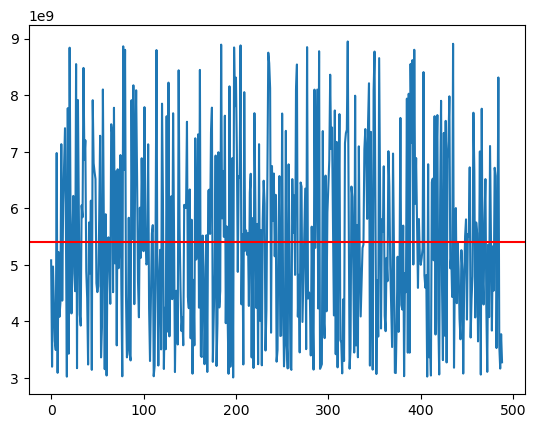

In [23]:
frd = Fr[80,:]
nz = np.where(frd!=0)
mean = np.mean(frd[nz])

plt.plot(frd[nz])
plt.axhline(mean, c='red')

Text(0, 0.5, 'Fr (mol)')

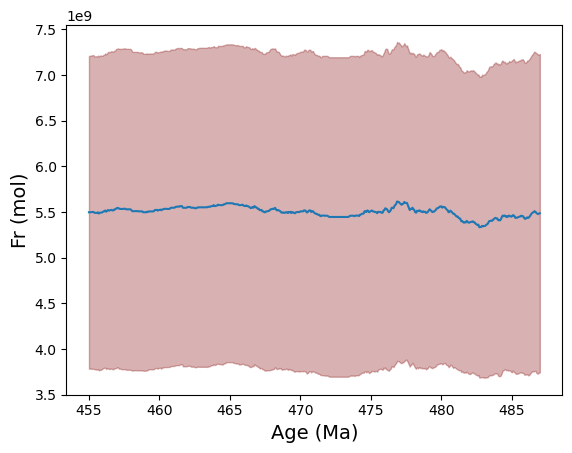

In [24]:
plt.plot(age, Fr_mean)
plt.fill_between(age, Fr_mean + Fr_stdev, Fr_mean - Fr_stdev,
                 color='maroon', alpha=0.3)
plt.xlabel('Age (Ma)', fontsize=14)
plt.ylabel('Fr (mol)', fontsize=14)

Text(0, 0.5, '$\\delta^7Li_{riv}$')

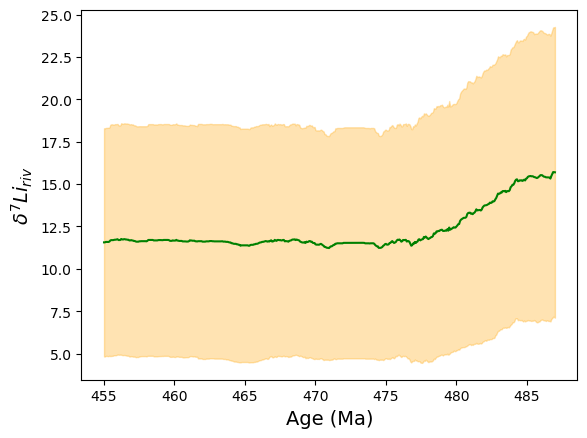

In [25]:
plt.plot(age, Rr_mean, c='green')
plt.fill_between(age, Rr_mean + Rr_stdev, Rr_mean - Rr_stdev,
                 color='orange', alpha=0.3)
plt.xlabel('Age (Ma)', fontsize=14)
plt.ylabel(r'$\delta^7Li_{riv}$', fontsize=14)

In [26]:
def estimate_WI_exp(d7Liriv):
    WI = 0.0077 * np.exp(0.0629*d7Liriv)
    return WI

def estimate_WI_lin(d7Liriv):
    WI = 0.0021*d7Liriv - 0.0131
    return WI

Text(0, 0.5, 'Weathering Intensity')

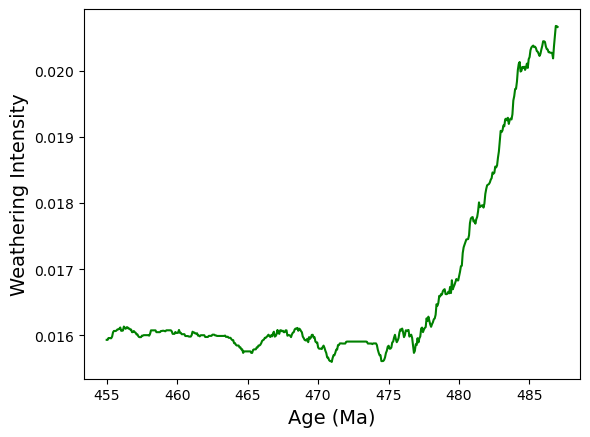

In [27]:
# Weathering intensity
plt.plot(age, estimate_WI_exp(Rr_mean), c='green')

plt.xlabel('Age (Ma)', fontsize=14)
plt.ylabel('Weathering Intensity', fontsize=14)

## Constrain in Hydrothermal FLux

In [28]:
fsr = pd.read_csv('../Data/Model/seafloor_production.csv')
fsr.head()

,age,fsr
0,550.0,0.800178
1,549.5,0.798341
2,549.0,0.796506
3,548.5,0.794672
4,548.0,0.792841


In [29]:
fsr['Fh'] = fsr['fsr'] * 13e9
fsr.head()

,age,fsr,Fh
0,550.0,0.800178,1.040231e+10
1,549.5,0.798341,1.037843e+10
2,549.0,0.796506,1.035457e+10
3,548.5,0.794672,1.033074e+10
4,548.0,0.792841,1.030693e+10


In [30]:
# Params
param = {
    'tmin' : 487,
    'tmax' : 455,
    'nt' : 500,

    'Fr' : [5e9, 10e9],
    'Rr' : [3, 35],
    'Fh' : [1e9, 11e9],
    'Rh' : [8, 8.1],
    'Fsed' : [1e9, 11e9],
    'Dsed' : [7.9, 8],
    'Falt' : [1e9, 11e9],
    'Dalt' : [1, 30],

    'sampling' : 1000
}

In [31]:
%%time
sol = run_sim(param, target_li, mode='hydrothermal_flux', 
              hydrothermal_flux=fsr['Fh'],
              hydrothermal_age=fsr['age'])

# unpack results
Fr = sol['Fr']
Rr = sol['Rr']
Fh = sol['Fh']
Rh = sol['Rh']
Fsed = sol['Fsed']
Dsed = sol['Dsed']
Falt = sol['Falt']
Dalt = sol['Dalt']
age = sol['age']

# Non-zeros mask to filter solutions
non_zero = np.where(Fr!=0)

# calculate mean and standard deviation of solutions
Fr_mean = np.zeros_like(age)
Fr_stdev = np.zeros_like(age)
Rr_mean = np.zeros_like(age)
Rr_stdev = np.zeros_like(age)

Fh_mean = np.zeros_like(age)
Fh_stdev = np.zeros_like(age)
Rh_mean = np.zeros_like(age)
Rh_stdev = np.zeros_like(age)

Fsed_mean = np.zeros_like(age)
Fsed_stdev = np.zeros_like(age)
Dsed_mean = np.zeros_like(age)
Dsed_stdev = np.zeros_like(age)

Falt_mean = np.zeros_like(age)
Falt_stdev = np.zeros_like(age)
Dalt_mean = np.zeros_like(age)
Dalt_stdev = np.zeros_like(age)

for i in range(len(age)):
    Fr_d = Fr[i,:]
    Rr_d = Rr[i,:]
    Fh_d = Fh[i,:]
    Rh_d = Rh[i,:]
    Fsed_d = Fsed[i,:]
    Dsed_d = Dsed[i,:]
    Falt_d = Falt[i,:]
    Dalt_d = Dalt[i,:]
    nz = np.where(Fr_d!=0)
    size = Fr_d[nz].size
    if size:
        Fr_mean[i] = np.mean(Fr_d[nz])
        Fr_stdev[i] = np.std(Fr_d[nz])
        Rr_mean[i] = np.mean(Rr_d[nz])
        Rr_stdev[i] = np.std(Rr_d[nz])

        Fh_mean[i] = np.mean(Fh_d[nz])
        Fh_stdev[i] = np.std(Fh_d[nz])
        Rh_mean[i] = np.mean(Rh_d[nz])
        Rh_stdev[i] = np.std(Rh_d[nz])

        Fsed_mean[i] = np.mean(Fsed_d[nz])
        Fsed_stdev[i] = np.std(Fsed_d[nz])
        Dsed_mean[i] = np.mean(Dsed_d[nz])
        Dsed_stdev[i] = np.std(Dsed_d[nz])

        Falt_mean[i] = np.mean(Falt_d[nz])
        Falt_stdev[i] = np.std(Falt_d[nz])
        Dalt_mean[i] = np.mean(Dalt_d[nz])
        Dalt_stdev[i] = np.std(Dalt_d[nz])

    else:
        Fr_mean[i] = np.nan
        Fr_stdev[i] = np.nan
        Rr_mean[i] = np.nan
        Rr_stdev[i] = np.nan

        Fh_mean[i] = np.nan
        Fh_stdev[i] = np.nan
        Rh_mean[i] = np.nan
        Rh_stdev[i] = np.nan

        Fsed_mean[i] = np.nan
        Fsed_stdev[i] = np.nan
        Dsed_mean[i] = np.nan
        Dsed_stdev[i] = np.nan

        Falt_mean[i] = np.nan
        Falt_stdev[i] = np.nan
        Dalt_mean[i] = np.nan
        Dalt_stdev[i] = np.nan

CPU times: total: 828 ms
Wall time: 1.07 s


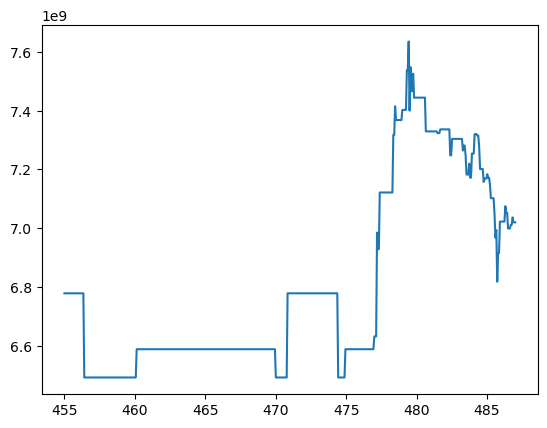

In [32]:
plt.plot(age, Fr_mean)

Text(0.5, 0, 'Age (Ma)')

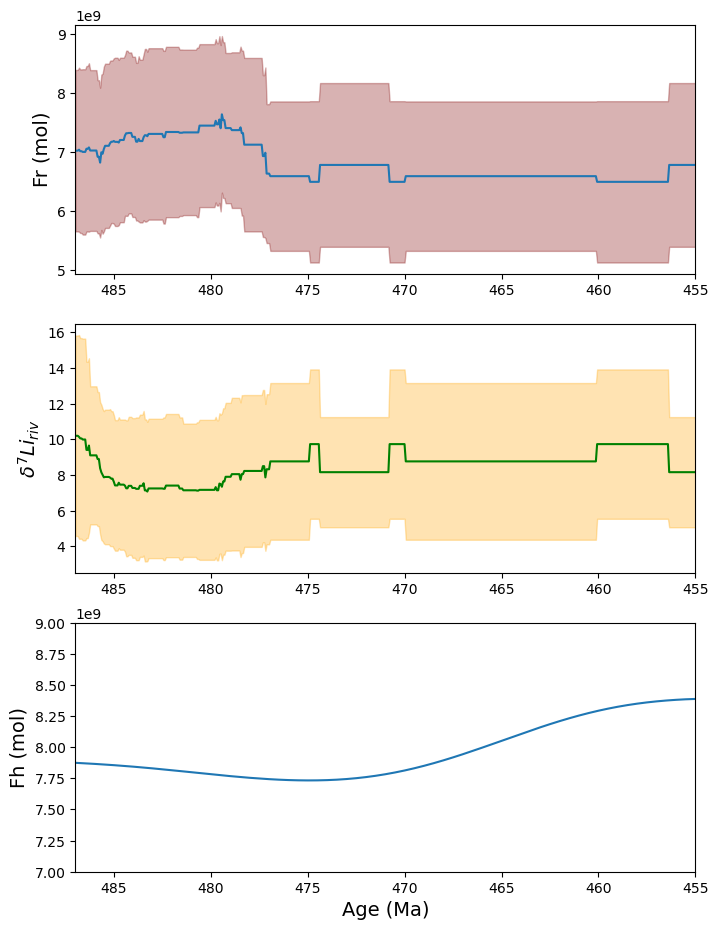

In [33]:
plt.figure(figsize=(8,11))

plt.subplot(311)
plt.plot(age, Fr_mean)
plt.fill_between(age, Fr_mean + Fr_stdev, Fr_mean - Fr_stdev,
                 color='maroon', alpha=0.3)

plt.ylabel('Fr (mol)', fontsize=14)
plt.xlim(487, 455)

plt.subplot(312)
plt.plot(age, Rr_mean, c='green')
plt.fill_between(age, Rr_mean + Rr_stdev, Rr_mean - Rr_stdev,
                 color='orange', alpha=0.3)

plt.ylabel(r'$\delta^7Li_{riv}$', fontsize=14)
plt.xlim(487, 455)

plt.subplot(313)
plt.plot(fsr['age'], fsr['Fh'])
plt.xlim(487, 455)
plt.ylim(7e9, 9e9)
plt.ylabel('Fh (mol)', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)

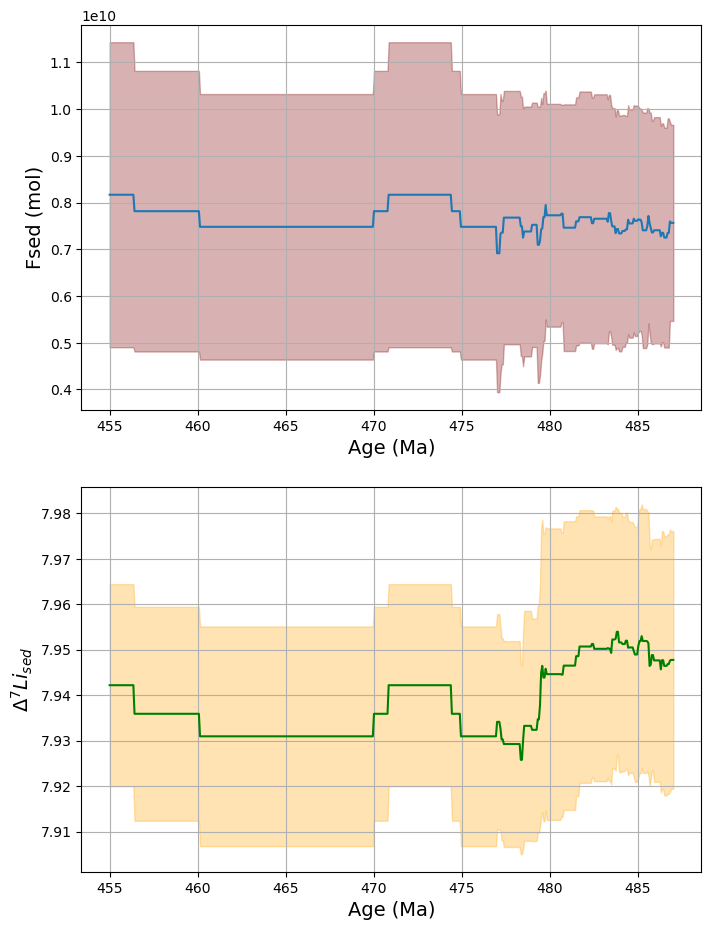

In [34]:
plt.figure(figsize=(8,11))

plt.subplot(211)
plt.plot(age, Fsed_mean)
plt.fill_between(age, Fsed_mean + Fsed_stdev, Fsed_mean - Fsed_stdev,
                 color='maroon', alpha=0.3)
plt.xlabel('Age (Ma)', fontsize=14)
plt.ylabel('Fsed (mol)', fontsize=14)
plt.grid()

plt.subplot(212)
plt.plot(age, Dsed_mean, c='green')
plt.fill_between(age, Dsed_mean + Dsed_stdev, Dsed_mean - Dsed_stdev,
                 color='orange', alpha=0.3)
plt.xlabel('Age (Ma)', fontsize=14)
plt.ylabel(r'$\Delta^7Li_{sed}$', fontsize=14)
plt.grid()

Text(0, 0.5, 'Weathering Intensity')

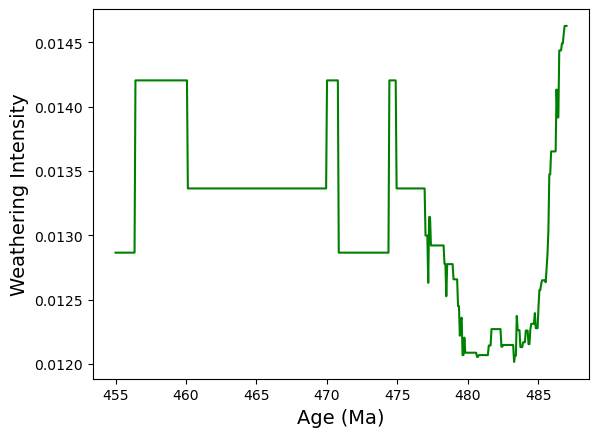

In [35]:
# Weathering intensity
plt.plot(age, estimate_WI_exp(Rr_mean), c='green')

plt.xlabel('Age (Ma)', fontsize=14)
plt.ylabel('Weathering Intensity', fontsize=14)

In [36]:
weat_intensity = estimate_WI_exp(Rr_mean)
print(np.max(weat_intensity))
print(np.min(weat_intensity))
print(np.min(weat_intensity)/np.max(weat_intensity))

0.014626893783592144
0.012015755262857105
0.8214837299451707


In [37]:
locality = [ 'Ibex', 'Shingle Pass']

locality_unc = ['Antelope Range',
 'Meiklejohn Peak', 'Clear Spring', 'Germany Valley']

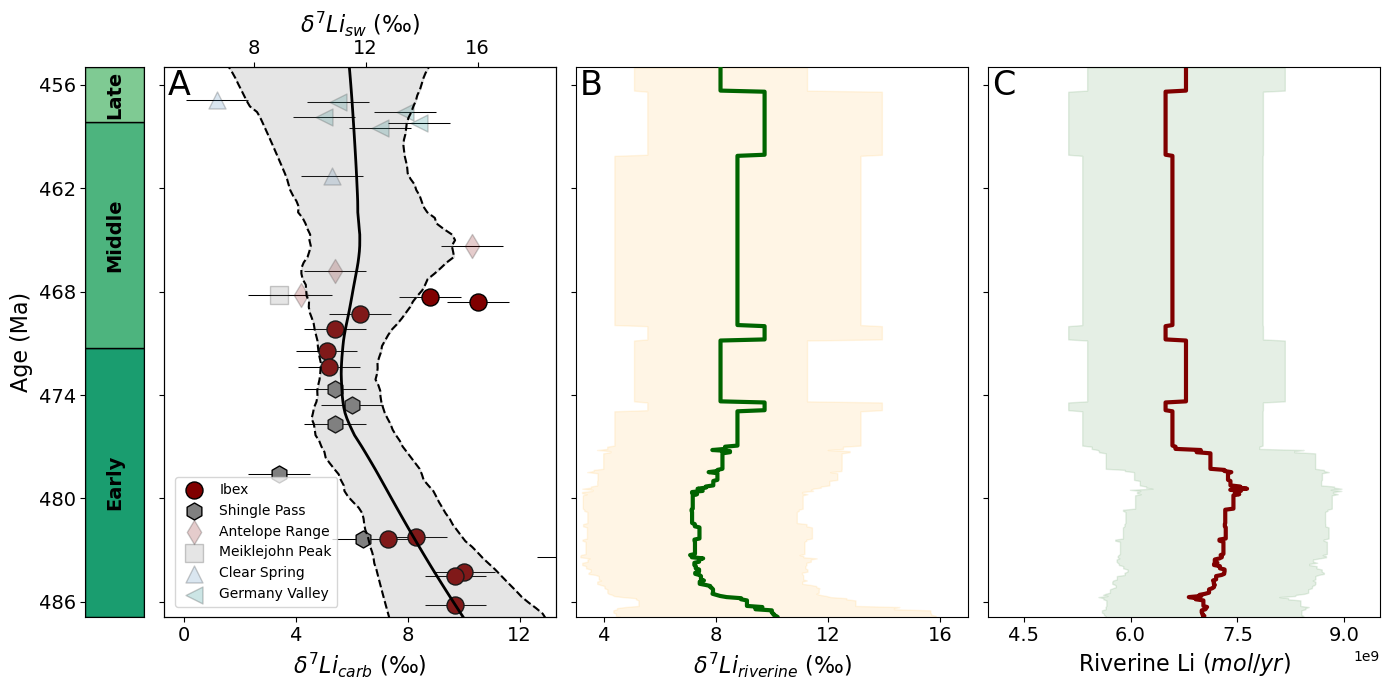

In [38]:
# Plotting

d7Li_df = pd.read_csv('../Data/Lithium/Ordovician_Lithium_Composite_Final.csv')
d7Li_loess_df = pd.read_csv('../Output/Ordovician_Li_Loess.csv')

# Bells and whistles for plotting

markers = ["o", "h", "^"]
colors = ['maroon', 'gray']

colors_unc = [ 'maroon', 'gray','steelblue', 'teal']
markers_unc = [ 'd', "s", "^", "<"]

ordo = pd.DataFrame({
    'epoch' : ['Early', 'Middle', 'Late'],
    'lower_boundary' : [486.85, 471.26, 458.18],
    'upper_boundary' : [471.26, 458.18, 455],
    'color' : ['#1A9D6F', '#4DB47E', '#7FCA93']
})

# Plotting Data
# Plot d7Li data
fig = plt.figure(figsize=(14, 7))

# width and height ratios
w = [0.15, 1, 1, 1]
h = [1]

# Gridspec
gs = fig.add_gridspec(ncols=4, nrows=1, width_ratios=w, height_ratios=h)

# Axes
ax0 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[0,1], sharey=ax0)
ax2 = fig.add_subplot(gs[0,2], sharey=ax0)
ax1 = fig.add_subplot(gs[0,3], sharey=ax0)

# Plot Ordovician Period
trans = ax0.get_yaxis_transform()
ordo['h'] = ordo['lower_boundary'] - ordo['upper_boundary']
rot = [90, 90, 90]
for ind in ordo.index:
    ax0.add_patch(Rectangle(xy=[0, ordo['upper_boundary'][ind]],
                            width=1,
                            height=ordo['h'][ind],
                            transform=trans, ec='black',
                            fc=ordo['color'][ind]))
    
    ax0.text(0.5, ordo['lower_boundary'][ind]-0.5*ordo['h'][ind], 
                str(ordo['epoch'][ind]), rotation=rot[ind],
                horizontalalignment='center', verticalalignment='center',
                transform = trans, fontsize=14, fontweight='bold')

# Plot Fr data
ax1.plot(Fr_mean, age, c='maroon', lw=3)
ax1.fill_betweenx(age, Fr_mean + Fr_stdev, Fr_mean - Fr_stdev,
                 color='darkgreen', alpha=0.1)
ax1.set_xlim(4e9, 9.5e9)

# Plot Rr data
ax2.plot(Rr_mean, age, lw=3, c='darkgreen', zorder=3)
ax2.fill_betweenx(age, Rr_mean + Rr_stdev, Rr_mean - Rr_stdev,
                 color='orange', alpha=0.1)
ax2.set_xlim(3, 17)


# Plot d7Li data
for i, s in enumerate(locality):
    ax3.scatter(d7Li_df['d7Li'].loc[d7Li_df.Locality == s], 
                d7Li_df['Age'].loc[d7Li_df.Locality == s],
                fc=colors[i],
                ec='k',
                s=150,
                marker=markers[i], label=s)

for i, s in enumerate(locality_unc):
    ax3.scatter(d7Li_df['d7Li'].loc[d7Li_df.Locality == s], 
                d7Li_df['Age'].loc[d7Li_df.Locality == s],
                fc=colors_unc[i],
                ec='k',
                s=150,
                marker=markers_unc[i], label=s, alpha=0.2)

ax3.legend(fontsize=10, loc='lower left', 
            bbox_to_anchor=(0.01, 0.005),
            title_fontsize=12)

ax3.set_ylim(486.85, 455)

xmin = -0.7
xmax = 13.3
ax3.set_xlim(xmin, xmax)

ax3t = ax3.twiny()
ax3t.set_xlim(xmin+5.5, xmax+5.5)
ax3t.set_xlabel('$\delta^{7}Li_{sw}$ (‰)', fontsize=16)
ax3t.xaxis.set_major_locator(plt.MaxNLocator(4))
ax3t.tick_params(axis='x', labelsize=14)

ax3.errorbar(d7Li_df['d7Li'], d7Li_df['Age'], xerr=1.1, fmt='none', ecolor='k',
             elinewidth=0.75, zorder=-3)

# Plot d7Li lowess
ax3.plot(d7Li_loess_df['d7Li'], d7Li_loess_df['Age'], 'k-', lw=2, zorder=3)
ax3.plot(d7Li_loess_df['upper95'], d7Li_loess_df['Age'], 'k--')
ax3.plot(d7Li_loess_df['lower95'], d7Li_loess_df['Age'], 'k--')
ax3.fill_betweenx(d7Li_loess_df['Age'], d7Li_loess_df['upper95'], 
                  d7Li_loess_df['lower95'], color='grey', alpha=0.2)


ax0.tick_params(axis='x', bottom=False, labelbottom=False)
ax0.set_ylabel('Age (Ma)', fontsize=16)
ax0.yaxis.set_major_locator(plt.MaxNLocator(6))
ax0.tick_params(axis='y', labelsize=14)

ax1.set_xlabel('Riverine Li $(mol/yr)$', fontsize=16)
ax2.set_xlabel('$\delta^7Li_{riverine}$ (‰)', fontsize=16)
ax3.set_xlabel('$\delta^{7}Li_{carb}$ (‰)', fontsize=16)

for ax, s in zip([ax1, ax2, ax3], ['C', 'B', 'A']):
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.tick_params(axis='y', labelleft=False)
    ax.tick_params(axis='x', labelsize=14)
    ax.text(0.01, 0.95, s, fontsize=24, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('../Figure/Model_Fr_Rr.png', dpi=300)
plt.savefig('../Figure/Model_Fr_Rr.svg')

In [39]:
(Fr_mean.max()-Fr_mean[0])/Fr_mean[0]

0.08764086280418529